# 파이토치 CIFAR10 모델
- 코드 출처: https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

## modules import

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

- 현재 GPU 설정

In [20]:
torch.cuda.is_available()

True

In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [22]:
device

device(type='cuda')

## 전처리 설정

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

## 데이터 로드 및 확인

In [24]:
train_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
train_loader = DataLoader(
    train_set,
    batch_size=4,
    shuffle=True,
    num_workers=6
)
test_loader = DataLoader(
    test_set,
    batch_size=4,
    shuffle=False,
    num_workers=6
)

In [26]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'flog', 'horse', 'ship', 'truck')

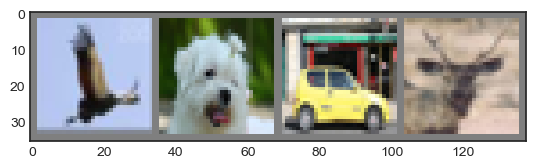

bird dog car deer


In [27]:
def imshow(img):
    img = img / 2 + .5
    np_img = img.numpy()
    
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()
    
data_iter = iter(train_loader)
imgs, labels = next(data_iter)

imshow(torchvision.utils.make_grid(imgs))

print(' '.join(f'{classes[labels[i]]}' for i in range(4)))

## 신경망 구성

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_2 = nn.Conv2d(6, 16, 5)
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv_1(x)))
        x = self.pool(F.relu(self.conv_2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        
        return x
    
net = Net().to(device)

## 손실함수와 옵티마이저

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=.9)

## 모델 학습

- 설명을 위해 `epochs=2`로 지정

In [31]:
for epoch in range(2):
    running_loss = .0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 2_000 == 1_999:
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 2_000}")
            running_loss = .0

Epoch: 1, Batch: 2000, Loss: 2.1880215582847593
Epoch: 1, Batch: 4000, Loss: 1.8674953479766845
Epoch: 1, Batch: 6000, Loss: 1.6924547026753425
Epoch: 1, Batch: 8000, Loss: 1.6011338859647513
Epoch: 1, Batch: 10000, Loss: 1.5386184369176625
Epoch: 1, Batch: 12000, Loss: 1.4596372595727443
Epoch: 2, Batch: 2000, Loss: 1.3949199736863376
Epoch: 2, Batch: 4000, Loss: 1.339486230686307
Epoch: 2, Batch: 6000, Loss: 1.360418033182621
Epoch: 2, Batch: 8000, Loss: 1.306878062672913
Epoch: 2, Batch: 10000, Loss: 1.292099093146622
Epoch: 2, Batch: 12000, Loss: 1.2872009307071566


## 모델의 저장 및 로드

In [34]:
PATH = './data/cifar-10-batches-py/cifar_net.pth'
torch.save(net.state_dict(), PATH)

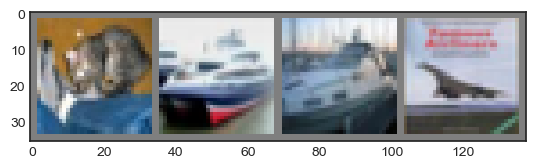

cat ship ship plane


In [35]:
data_iter = iter(test_loader)
imgs, labels = next(data_iter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join(f'{classes[labels[i]]}' for i in range(4)))

In [36]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트

In [37]:
outputs = net(imgs.to(device))

In [38]:
pred_vals, pred_indices = torch.max(outputs, 1)

print(' '.join(f'{classes[pred_indices[i]]}' for i in range(4)))

ship car car ship


In [39]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        imgs, labels = data[0].to(device), data[1].to(device)
        outputs = net(imgs)
        _, pred_indices = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (pred_indices == labels).sum().item()

print(100 * correct / total)

55.12


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [40]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        imgs, labels = data[0].to(device), data[1].to(device)
        outputs = net(imgs)
        _, pred_indices = torch.max(outputs, 1)
        c = (pred_indices == labels).squeeze()
        
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f"Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]}%")

Accuracy of plane: 72.3%
Accuracy of car: 66.6%
Accuracy of bird: 44.6%
Accuracy of cat: 22.3%
Accuracy of deer: 43.7%
Accuracy of dog: 41.0%
Accuracy of flog: 75.7%
Accuracy of horse: 48.9%
Accuracy of ship: 71.9%
Accuracy of truck: 64.2%
